# AI-based Surveying the Impact of Environmental, Climatic, Economic and Demographic Conditions on the Epidemic Outbreak Rate of COVID-19

$Mehryar{\,}Majd$, $Ramin{\,}Mousa$ \& $Arsalan{\,}Mousazadeh$

__Abstract:__ This study aims to have an analytical and predictive approach to the growth rate and spread of the first wave of COVID-19 infection and mainly focuses on its dependency on other global factors in affected countries via Artificial Intelligence-based processing of fatality data/statistics. Fatality, infected, and recovered cases in the form of the time-series data was acquired through the World Health Organization (WHO) & the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). Recorded health data subsequently was analyzed by several Deep Neural Network (DNN) models to create a better intuition of epidemic outbreak rate of COVID-19. Monitoring spreading trend changes becomes more feasible via continuous observation of statistical pattern and integrating the other datasets with more global features count as factors influencing the local conditions on historical data conveys pivotal information concerning learning the pattern of epidemic progression. In this study, attention-based Sequence-to-Sequence (Seq2Seq) models empowered by Long-Short Term Memory (LSTM) and Gated Recurrent Unit (GRU) units, were deployed to predict mortality rate. Ultimately these analyses are utilized to monitor infection behaviour on time-series data and were subsequently assessed for their performance to predict the behaviour of the first wave of COVID-19 outbreak rate intensely. Demographic & environmental conditions have likely been influenced significantly to shape the reliable predictive learning algorithms for long-duration risk of COVID-19 pandemic.

### Prediction on COVID-19 data including Climatic, Economic and Demographic and epidemics datasets
![img](https://i.imgur.com/4mmKSwy.png)

# __Data Cleaning & Preprocessing__

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from matplotlib import pyplot as plt
import os
df_covid_19 = pd.read_csv("novel-corona-virus/covid_19_data.csv")
df_covid_19['Date'] = pd.to_datetime(df_covid_19['ObservationDate'])
df_covid_19['Outbreak'] = 'COVID_2019'

## Covid data 

In [4]:
copy_covid=df_covid_19.copy()
copy_covid['Province/State'] = copy_covid['Province/State'].astype('category')
copy_covid['Country/Region'] = copy_covid['Country/Region'].astype('category')
copy_covid['Province/State'] = copy_covid['Province/State'].cat.codes
copy_covid['Country/Region'] = copy_covid['Country/Region'].cat.codes
copy_covid['Month'] = copy_covid['Date'].dt.month
copy_covid['Week'] = copy_covid['Date'].dt.week
copy_covid.head(2)
data_Deaths=copy_covid[['Province/State', 'Country/Region','Month', 'Week', 'Deaths']]
data_Recovered=copy_covid[['Province/State', 'Country/Region','Month', 'Week', 'Recovered']]
data_Confirmed=copy_covid[['Province/State', 'Country/Region','Month', 'Week', 'Confirmed']]

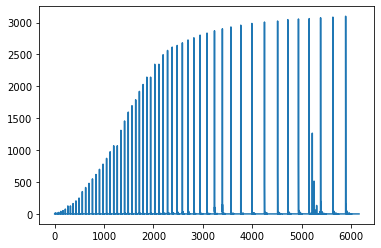

In [5]:
plt.plot(data_Deaths.Deaths)

# concatinate with Sars data

In [8]:
df_sars_03 = pd.read_csv("novel-corona-virus/sars_2003_complete_dataset_clean.csv")
df_sars_03['Date'] = pd.to_datetime(df_sars_03['Date'])
df_sars_03['Province/State'] = None
df_sars_03['Outbreak'] = 'SARS_2003'
df_sars_03.rename({'Cumulative number of case(s)':'Confirmed', 'Number of deaths':'Deaths', 'Number recovered':'Recovered', 'Country':'Country/Region'},axis=1,inplace=True)
templ_cols = ['Outbreak', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']
df = pd.concat([df_covid_19[templ_cols], df_sars_03[templ_cols]])
df = df.reset_index(drop=True)
df['Confirmed'] = df['Confirmed'].fillna(0)
df['Province/State'] = df['Province/State'].fillna('Others')
df = df.sort_values(['Country/Region','Province/State','Date'])
df.head()

,Outbreak,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
2663,COVID_2019,Others,Azerbaijan,2020-02-28,1.0,0.0,0.0
4674,COVID_2019,Others,"('St. Martin',)",2020-03-10,2.0,0.0,0.0
2258,COVID_2019,Others,Afghanistan,2020-02-24,1.0,0.0,0.0
2351,COVID_2019,Others,Afghanistan,2020-02-25,1.0,0.0,0.0
2452,COVID_2019,Others,Afghanistan,2020-02-26,1.0,0.0,0.0


In [9]:
set(df['Outbreak'])

{'COVID_2019', 'SARS_2003'}

In [10]:
t = df.groupby(['Outbreak','Country/Region','Province/State']).agg({'Confirmed':'max'})
t = t.loc[t['Confirmed'] >=0]
df = pd.merge(df,t[[]],left_on=['Outbreak','Country/Region','Province/State'], right_index=True)
df['Province/State'] = df['Province/State'].astype('category')
df['Country/Region'] = df['Country/Region'].astype('category')
df['Outbreak'] = df['Outbreak'].astype('category')
df['Province/State'] = df['Province/State'].cat.codes
df['Country/Region'] = df['Country/Region'].cat.codes
df['Outbreak'] = df['Outbreak'].cat.codes
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week
df.head(2)

,Outbreak,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Month,Week
2663,0,175,0,2020-02-28,1.0,0.0,0.0,2,9
4674,0,175,1,2020-03-10,2.0,0.0,0.0,3,11


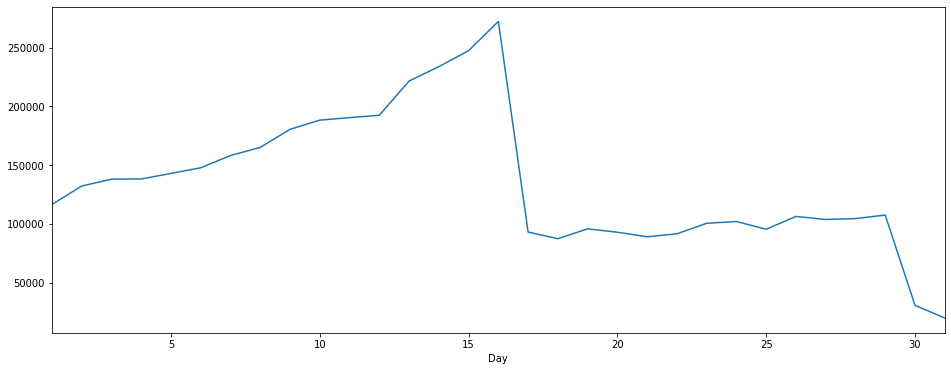

In [11]:
df['Day'] = df['Date'].apply(lambda x:x.day)
df['Hour'] = df['Date'].apply(lambda x:x.hour)
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,6))
df.groupby('Day').sum()['Confirmed'].plot()

# All Country

In [13]:
Confirmed = df.groupby('Day').sum()['Confirmed']
Deaths = df.groupby('Day').sum()['Deaths']
Recovered = df.groupby('Day').sum()['Recovered']

In [14]:
df=df[[ 'Province/State', 'Country/Region', 'Day','Confirmed','Deaths','Recovered']]

In [48]:
'''df = pd.DataFrame(data=[Confirmed, Deaths,Recovered])
df = df.T'''

In [15]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM,GRU
from keras.layers import Dense
def load_data(data, time_step=2, after_day=1, validate_percent=0.67):
    seq_length = time_step + after_day
    result = []
    for index in range(len(data) - seq_length + 1):
        result.append(data[index: index + seq_length])
    result = np.array(result)
    print('total data: ', result.shape)

    train_size = int(len(result) * validate_percent)
    train = result[:train_size, :]
    validate = result[train_size:, :]

    x_train = train[:, :time_step]
    y_train = train[:, time_step:]
    x_validate = validate[:, :time_step]
    y_validate = validate[:, time_step:]
    
     

    return [x_train, y_train, x_validate, y_validate]
def base_model(feature_len=3, after_day=3, input_shape=(8, 1)):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    #model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    # one to many
    model.add(RepeatVector(after_day))
    #model.add(LSTM(200, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(units=feature_len, activation='linear')))
    return model

def seq2seq(feature_len=1, after_day=1, input_shape=(8, 1)):
    '''
    Encoder:
    X = Input sequence
    C = LSTM(X); The context vector

    Decoder:
    y(t) = LSTM(s(t-1), y(t-1)); where s is the hidden state of the LSTM(h and c)
    y(0) = LSTM(s0, C); C is the context vector from the encoder.
    '''

    # Encoder
    encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    encoder = LSTM(units=100, return_state=True,  name='encoder')
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 100), name='reshapor')
    decoder = LSTM(units=100, return_sequences=True, return_state=True, name='decoder')

    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=feature_len, activation='linear', name='output')

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []



    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

Using TensorFlow backend.


In [27]:
def normalize_data(data, scaler, feature_len):
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)
    return normalize_data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = normalize_data(df, scaler,df.shape[1])
x_train, y_train, x_validate, y_validate = load_data(data,time_step=2, after_day=4, validate_percent=0.8)
print('train data: ', x_train.shape, y_train.shape)
print('validate data: ', x_validate.shape, y_validate.shape)

total data:  (8695, 6, 6)
train data:  (6956, 2, 6) (6956, 4, 6)
validate data:  (1739, 2, 6) (1739, 4, 6)


In [18]:
from keras import backend as K
from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape
from keras.callbacks import ModelCheckpoint
# model complie
from keras.optimizers import SGD,Adam
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
input_shape = (2, data.shape[1])
model = base_model(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc',rmse,mse,r_square])
# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=7, verbose=1, min_delta=1e-4, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=100, verbose=0, mode='max')
history = model.fit(x_train, y_train, batch_size=256,epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

Instructions for updating:
Use tf.cast instead.
Train on 6956 samples, validate on 1739 samples
Epoch 1/100
6956/6956 [==============================] - 2s 349us/step - loss: 0.0875 - acc: 0.2595 - rmse: 0.2851 - mse: 0.0875 - r_square: -0.0070 - val_loss: 0.0616 - val_acc: 0.3452 - val_rmse: 0.2356 - val_mse: 0.0616 - val_r_square: 0.5730
Epoch 2/100
6956/6956 [==============================] - 1s 116us/step - loss: 0.0434 - acc: 0.3986 - rmse: 0.1910 - mse: 0.0434 - r_square: 0.5105 - val_loss: 0.0484 - val_acc: 0.5512 - val_rmse: 0.2066 - val_mse: 0.0484 - val_r_square: 0.6638
Epoch 3/100
6956/6956 [==============================] - 1s 112us/step - loss: 0.0326 - acc: 0.4804 - rmse: 0.1649 - mse: 0.0326 - r_square: 0.6327 - val_loss: 0.0335 - val_acc: 0.8026 - val_rmse: 0.1682 - val_mse: 0.0335 - val_r_square: 0.7661
Epoch 4/100
6956/6956 [==============================] - 1s 129us/step - loss: 0.0274 - acc: 0.5472 - rmse: 0.1497 - mse: 0.0274 - r_square: 0.6869 - val_loss: 0.0230 -

6956/6956 [==============================] - 1s 100us/step - loss: 0.0077 - acc: 0.8378 - rmse: 0.0575 - mse: 0.0077 - r_square: 0.9133 - val_loss: 0.0069 - val_acc: 0.9658 - val_rmse: 0.0568 - val_mse: 0.0069 - val_r_square: 0.9521
Epoch 34/100
6956/6956 [==============================] - 1s 96us/step - loss: 0.0076 - acc: 0.8441 - rmse: 0.0570 - mse: 0.0076 - r_square: 0.9141 - val_loss: 0.0067 - val_acc: 0.9694 - val_rmse: 0.0556 - val_mse: 0.0067 - val_r_square: 0.9534
Epoch 35/100
6956/6956 [==============================] - 1s 99us/step - loss: 0.0075 - acc: 0.8476 - rmse: 0.0566 - mse: 0.0075 - r_square: 0.9147 - val_loss: 0.0066 - val_acc: 0.9678 - val_rmse: 0.0546 - val_mse: 0.0066 - val_r_square: 0.9544
Epoch 36/100
6956/6956 [==============================] - 1s 131us/step - loss: 0.0075 - acc: 0.8507 - rmse: 0.0562 - mse: 0.0075 - r_square: 0.9153 - val_loss: 0.0065 - val_acc: 0.9665 - val_rmse: 0.0539 - val_mse: 0.0065 - val_r_square: 0.9551
Epoch 37/100
6956/6956 [=======

6956/6956 [==============================] - 1s 112us/step - loss: 0.0063 - acc: 0.8961 - rmse: 0.0522 - mse: 0.0063 - r_square: 0.9294 - val_loss: 0.0053 - val_acc: 0.9435 - val_rmse: 0.0490 - val_mse: 0.0053 - val_r_square: 0.9633
Epoch 100/100
6956/6956 [==============================] - 1s 104us/step - loss: 0.0063 - acc: 0.9081 - rmse: 0.0497 - mse: 0.0063 - r_square: 0.9288 - val_loss: 0.0055 - val_acc: 0.9641 - val_rmse: 0.0510 - val_mse: 0.0055 - val_r_square: 0.9621


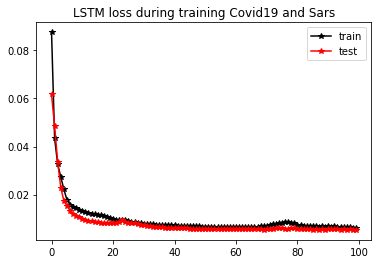

In [19]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("LSTM loss during training Covid19 and Sars")
plt.savefig("LSTMLOSS_Covid19_Sars.pdf", bbox_inches='tight')
plt.show()

In [20]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )
validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))

train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

train_predict= inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate= inverse_normalize_data(y_validate, scaler)

----------------------------------------------------------------------------------------------------
Train Score: 0.00634437 MSE (0.07965153 RMSE ) , 89.76782643  ACC
Validation Score: 0.00547190 MSE (0.07397227 RMSE ) , 96.40598042  ACC


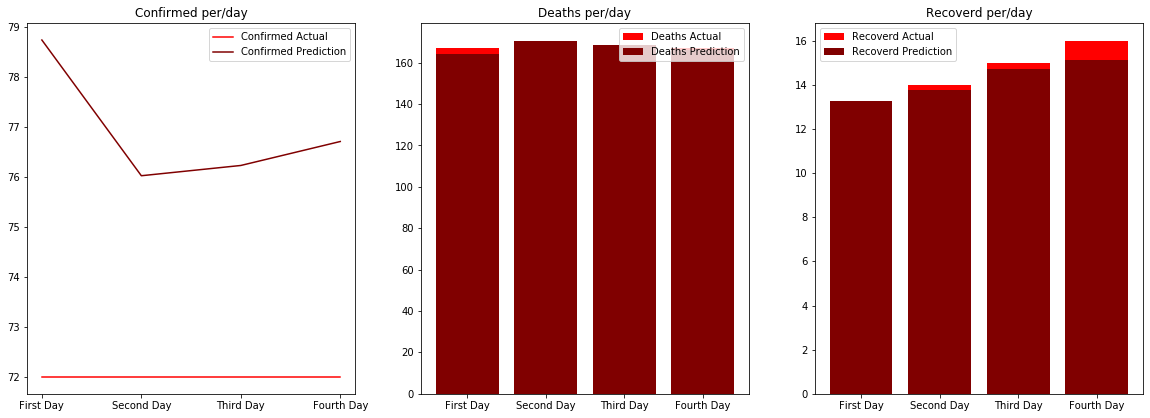

In [21]:

#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,1][0],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,1][0],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,2][0],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,2][0],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()
plt.savefig("LSTMprediction for4 days.pdf", bbox_inches='tight')

plt.show()

# Seq2Seq

In [24]:
 # model complie
from keras.optimizers import SGD,Adam
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
input_shape = (2, data.shape[1])
model = seq2seq(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc',rmse,mse,r_square])
# mlp overfit on the moons dataset with patient early stopping and model checkpointing
from sklearn.datasets import make_moons
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=7, verbose=1, min_delta=1e-4, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=100, verbose=0, mode='max')
history = model.fit(x_train, y_train, batch_size=256,epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

Train on 6956 samples, validate on 1739 samples
Epoch 1/100
6956/6956 [==============================] - 5s 691us/step - loss: 0.0601 - acc: 0.4101 - rmse: 0.2273 - mse: 0.0601 - r_square: 0.2684 - val_loss: 0.0250 - val_acc: 0.9408 - val_rmse: 0.1459 - val_mse: 0.0250 - val_r_square: 0.8223
Epoch 2/100
6956/6956 [==============================] - 1s 149us/step - loss: 0.0289 - acc: 0.2889 - rmse: 0.1562 - mse: 0.0289 - r_square: 0.6659 - val_loss: 0.0260 - val_acc: 0.6890 - val_rmse: 0.1509 - val_mse: 0.0260 - val_r_square: 0.8145
Epoch 3/100
6956/6956 [==============================] - 1s 151us/step - loss: 0.0222 - acc: 0.5399 - rmse: 0.1335 - mse: 0.0222 - r_square: 0.7424 - val_loss: 0.0176 - val_acc: 0.9482 - val_rmse: 0.1204 - val_mse: 0.0176 - val_r_square: 0.8755
Epoch 4/100
6956/6956 [==============================] - 1s 150us/step - loss: 0.0182 - acc: 0.6757 - rmse: 0.1168 - mse: 0.0182 - r_square: 0.7888 - val_loss: 0.0113 - val_acc: 0.9408 - val_rmse: 0.0899 - val_mse: 0.

6956/6956 [==============================] - 1s 139us/step - loss: 0.0059 - acc: 0.8619 - rmse: 0.0493 - mse: 0.0059 - r_square: 0.9333 - val_loss: 0.0050 - val_acc: 0.9546 - val_rmse: 0.0462 - val_mse: 0.0050 - val_r_square: 0.9654
Epoch 68/100
6956/6956 [==============================] - 1s 143us/step - loss: 0.0064 - acc: 0.8529 - rmse: 0.0552 - mse: 0.0064 - r_square: 0.9285 - val_loss: 0.0053 - val_acc: 0.9508 - val_rmse: 0.0520 - val_mse: 0.0053 - val_r_square: 0.9633
Epoch 69/100
6956/6956 [==============================] - 1s 139us/step - loss: 0.0066 - acc: 0.8459 - rmse: 0.0570 - mse: 0.0066 - r_square: 0.9266 - val_loss: 0.0057 - val_acc: 0.9503 - val_rmse: 0.0564 - val_mse: 0.0057 - val_r_square: 0.9610
Epoch 70/100
6956/6956 [==============================] - 1s 138us/step - loss: 0.0059 - acc: 0.8611 - rmse: 0.0487 - mse: 0.0059 - r_square: 0.9336 - val_loss: 0.0050 - val_acc: 0.9403 - val_rmse: 0.0474 - val_mse: 0.0050 - val_r_square: 0.9652
Epoch 71/100
6956/6956 [=====

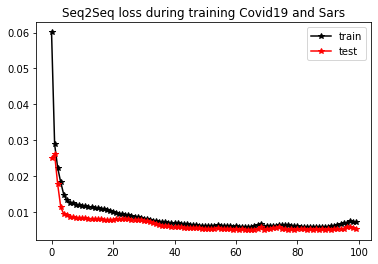

In [25]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("Seq2Seq loss during training Covid19 and Sars")
plt.savefig("Seq2SeqLOSS_Covid19_Sars.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.02679694 MSE (0.16369770 RMSE ) , 83.75000060  ACC
Validation Score: 0.01818028 MSE (0.13483427 RMSE ) , 66.66666567  ACC


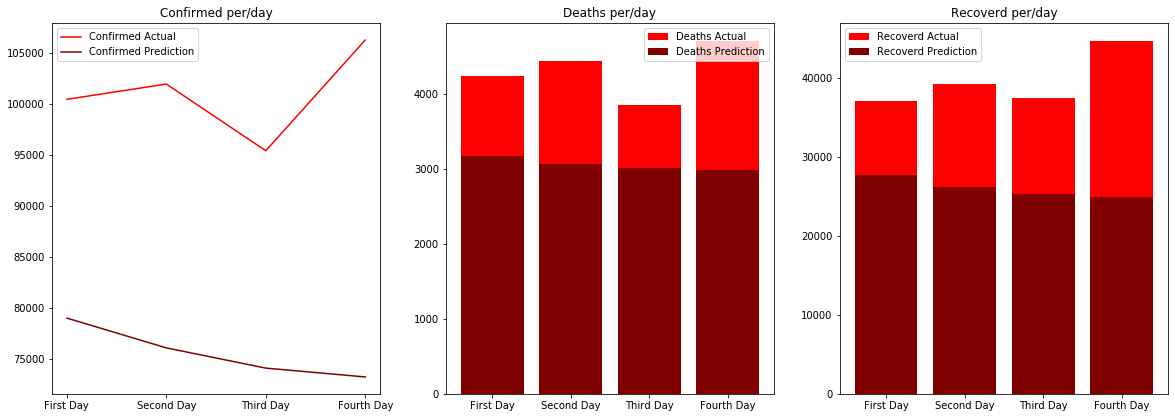

In [92]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
        #test_predict = model.predict(x_test)

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,1][0],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,1][0],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,2][0],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,2][0],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()
plt.savefig("Seq2Seqprediction for4 days.pdf", bbox_inches='tight')
plt.show()

# GRU Model

In [28]:
def base_model2(feature_len=3, after_day=3, input_shape=(8, 1)):
    model = Sequential()
    model.add(GRU(units=100, return_sequences=False, input_shape=input_shape))
    #model.add(LSTM(units=100, return_sequences=False, input_shape=input_shape))
    # one to many
    model.add(RepeatVector(after_day))
    #model.add(LSTM(200, return_sequences=True))
    model.add(GRU(50, return_sequences=True))
    model.add(TimeDistributed(Dense(units=feature_len, activation='linear')))
    return model
opt = Adam(lr=0.01)
input_shape = (2, data.shape[1])
model = base_model2(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer=opt,metrics=['acc',mse,rmse,r_square])
model.summary()
history = model.fit(x_train, y_train, batch_size=256, epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               32100     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 100)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 4, 50)             22650     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 6)              306       
Total params: 55,056
Trainable params: 55,056
Non-trainable params: 0
_________________________________________________________________
Train on 6956 samples, validate on 1739 samples
Epoch 1/100
6956/6956 [==============================] - 3s 467us/step - loss: 0.0255 - acc: 0.5729 - mse: 0.0255 - rmse: 0.1408 - r_square: 0.7038 - val_loss: 0.0213 - val_acc: 0.9238 - val_mse: 0.0213 - val_rmse: 0.1316 

Epoch 31/100
6956/6956 [==============================] - 1s 87us/step - loss: 0.0078 - acc: 0.8098 - mse: 0.0078 - rmse: 0.0663 - r_square: 0.9124 - val_loss: 0.0059 - val_acc: 0.9432 - val_mse: 0.0059 - val_rmse: 0.0530 - val_r_square: 0.9592
Epoch 32/100
6956/6956 [==============================] - 1s 89us/step - loss: 0.0078 - acc: 0.8079 - mse: 0.0078 - rmse: 0.0671 - r_square: 0.9114 - val_loss: 0.0061 - val_acc: 0.9403 - val_mse: 0.0061 - val_rmse: 0.0624 - val_r_square: 0.9574
Epoch 33/100
6956/6956 [==============================] - 1s 88us/step - loss: 0.0083 - acc: 0.8360 - mse: 0.0083 - rmse: 0.0665 - r_square: 0.9055 - val_loss: 0.0061 - val_acc: 0.9747 - val_mse: 0.0061 - val_rmse: 0.0583 - val_r_square: 0.9572
Epoch 34/100
6956/6956 [==============================] - 1s 86us/step - loss: 0.0070 - acc: 0.8688 - mse: 0.0070 - rmse: 0.0612 - r_square: 0.9208 - val_loss: 0.0054 - val_acc: 0.9620 - val_mse: 0.0054 - val_rmse: 0.0515 - val_r_square: 0.9623
Epoch 35/100
6956/69

6956/6956 [==============================] - 1s 83us/step - loss: 0.0058 - acc: 0.9128 - mse: 0.0058 - rmse: 0.0462 - r_square: 0.9346 - val_loss: 0.0052 - val_acc: 0.9426 - val_mse: 0.0052 - val_rmse: 0.0519 - val_r_square: 0.9643
Epoch 98/100
6956/6956 [==============================] - 1s 82us/step - loss: 0.0054 - acc: 0.9108 - mse: 0.0054 - rmse: 0.0445 - r_square: 0.9389 - val_loss: 0.0052 - val_acc: 0.9435 - val_mse: 0.0052 - val_rmse: 0.0532 - val_r_square: 0.9637
Epoch 99/100
6956/6956 [==============================] - 1s 87us/step - loss: 0.0057 - acc: 0.9099 - mse: 0.0057 - rmse: 0.0450 - r_square: 0.9354 - val_loss: 0.0050 - val_acc: 0.9408 - val_mse: 0.0050 - val_rmse: 0.0500 - val_r_square: 0.9653
Epoch 100/100
6956/6956 [==============================] - 1s 82us/step - loss: 0.0057 - acc: 0.9058 - mse: 0.0057 - rmse: 0.0463 - r_square: 0.9353 - val_loss: 0.0051 - val_acc: 0.9412 - val_mse: 0.0051 - val_rmse: 0.0508 - val_r_square: 0.9647


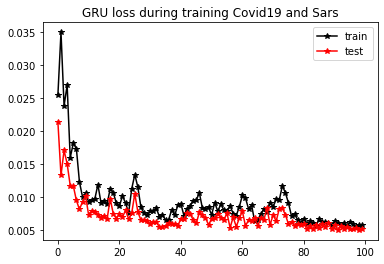

In [29]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("GRU loss during training Covid19 and Sars")
plt.savefig("GRULOSS_Covid19_Sars.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.01716431 MSE (0.13101264 RMSE ) , 76.25000030  ACC
Validation Score: 0.02403931 MSE (0.15504616 RMSE ) , 75.00000000  ACC


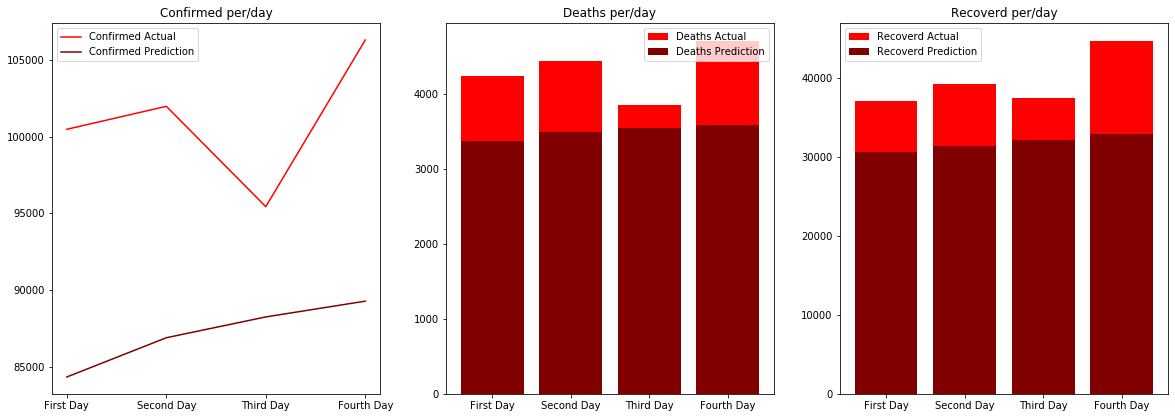

In [99]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
        #test_predict = model.predict(x_test)

def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,1][0],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,1][0],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,2][0],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,2][0],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()
plt.savefig("GRUprediction for4 days.pdf", bbox_inches='tight')
plt.show()

# countries of the world properties +Covid19+Sars

In [30]:
#df_covid_19 = pd.read_csv('../input/corona-virus-report/covid_19_clean_complete.csv')
df_covid_19 = pd.read_csv("novel-corona-virus/covid_19_data.csv")
df_covid_19['Date'] = pd.to_datetime(df_covid_19['ObservationDate'])
df_covid_19['Outbreak'] = 'COVID_2019'
df_sars_03 = pd.read_csv("novel-corona-virus/sars_2003_complete_dataset_clean.csv")
df_sars_03['Date'] = pd.to_datetime(df_sars_03['Date'])
df_sars_03['Province/State'] = None
df_sars_03['Outbreak'] = 'SARS_2003'
print(df_sars_03.columns)
df_sars_03.rename({'Cumulative number of case(s)':'Confirmed', 'Number of deaths':'Deaths', 'Number recovered':'Recovered', 'Country':'Country/Region'},axis=1,inplace=True)
templ_cols = ['Outbreak', 'Province/State', 'Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']
df = pd.concat([df_covid_19[templ_cols], df_sars_03[templ_cols]])
df.head()
df = df.reset_index(drop=True)
df['Confirmed'] = df['Confirmed'].fillna(0)
df['Province/State'] = df['Province/State'].fillna('Others')
df = df.sort_values(['Country/Region','Province/State','Date'])
df.head()

df['Province/State'] = 'all'
df.head()
t = df.groupby(['Outbreak','Country/Region','Province/State']).agg({'Confirmed':'max'})
t = t.loc[t['Confirmed'] >=0]
df = pd.merge(df,t,left_on=['Outbreak','Country/Region','Province/State'], right_index=True)
df.head()

country_data = pd.read_csv("novel-corona-virus/countries of the world.csv")
country_data['Country'] = country_data['Country'].str.strip()
country_data.head(2)
df.loc[df['Country/Region']=='US','Country/Region'] = 'United States'
df.loc[df['Country/Region']=='Mainland China','Country/Region'] = 'China'
df.loc[df['Country/Region']=='Viet Nam','Country/Region'] = 'Vietnam'
df.loc[df['Country/Region']=='UK','Country/Region'] = 'United Kingdom'
df.loc[df['Country/Region']=='South Korea','Country/Region'] = 'Korea, South'
df.loc[df['Country/Region']=='Taiwan, China','Country/Region'] = 'Taiwan'
df.loc[df['Country/Region']=='Hong Kong SAR, China','Country/Region'] = 'Hong Kong'

df = pd.merge(df, country_data, how='left', left_on=['Country/Region'], right_on=['Country'])
df['Date'] = pd.to_datetime(df['Date'])
df.loc[df['Country'].isnull()]['Country/Region'].value_counts()

Index(['Date', 'Country', 'Cumulative number of case(s)', 'Number of deaths',
       'Number recovered', 'Province/State', 'Outbreak'],
      dtype='object')


Republic of Ireland               93
Republic of Korea                 59
Macao SAR, China                  58
Others                            39
Russian Federation                31
North Macedonia                   20
Bosnia and Herzegovina            12
Holy See                           7
Saint Barthelemy                   7
Ivory Coast                        7
occupied Palestinian territory     6
Congo (Kinshasa)                   6
Palestine                          5
Vatican City                       4
Antigua and Barbuda                4
Trinidad and Tobago                3
Eswatini                           3
Congo (Brazzaville)                2
Central African Republic           2
Curacao                            2
Kosovo                             2
Channel Islands                    1
('St. Martin',)                    1
The Bahamas                        1
North Ireland                      1
St. Martin                         1
Republic of the Congo              1
 

In [31]:
df.loc[df['Region'].isnull(), 'Region'] = 'Others'
df.loc[df['Country'].isnull(), 'Country'] = 'Undefined'
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.week
df = df.fillna(0)
df=df.drop('Other (%)',axis=1)
df.head()

,Outbreak,Province/State,Country/Region,Date,Confirmed_x,Deaths,Recovered,Confirmed_y,Country,Region,...,Arable (%),Crops (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Month,Week
0,COVID_2019,all,Azerbaijan,2020-02-28,1.0,0.0,0.0,1.0,Undefined,Others,...,0,0,0,0,0,0,0,0,2,9
1,COVID_2019,all,"('St. Martin',)",2020-03-10,2.0,0.0,0.0,2.0,Undefined,Others,...,0,0,0,0,0,0,0,0,3,11
2,COVID_2019,all,Afghanistan,2020-02-24,1.0,0.0,0.0,21.0,Afghanistan,ASIA (EX. NEAR EAST),...,"12,13","0,22",1,"46,6","20,34","0,38","0,24","0,38",2,9
3,COVID_2019,all,Afghanistan,2020-02-25,1.0,0.0,0.0,21.0,Afghanistan,ASIA (EX. NEAR EAST),...,"12,13","0,22",1,"46,6","20,34","0,38","0,24","0,38",2,9
4,COVID_2019,all,Afghanistan,2020-02-26,1.0,0.0,0.0,21.0,Afghanistan,ASIA (EX. NEAR EAST),...,"12,13","0,22",1,"46,6","20,34","0,38","0,24","0,38",2,9


In [32]:
import locale
from fastnumbers import fast_real
Literacy=[]
Pop,Pho,Agric=[],[],[]
Coa,Clim,Bir,Dea=[],[],[],[]
Net,Inf,Arab,Crop,Ind,Serv=[],[],[],[],[],[]
for index ,row in df.iterrows():
    a=str(row['Literacy (%)']).replace(',','.')
    Literacy.append(fast_real(a))
    #----------
    a=str(row['Pop. Density (per sq. mi.)']).replace(',','.')
    Pop.append(fast_real(a))
    #----------
    a=str(row['Coastline (coast/area ratio)']).replace(',','.')
    Coa.append(fast_real(a))
    #-----------
    a=str(row['Net migration']).replace(',','.')
    Net.append(fast_real(a))
    #-----------
    a=str(row['Infant mortality (per 1000 births)']).replace(',','.')
    Inf.append(fast_real(a))
    #
    #
    a=str(row['Phones (per 1000)']).replace(',','.')
    Pho.append(fast_real(a))
    #
    a=str(row['Arable (%)']).replace(',','.')
    Arab.append(fast_real(a))
    #
    a=str(row['Crops (%)']).replace(',','.')
    Crop.append(fast_real(a))
    #
    a=str(row['Climate']).replace(',','.')
    Clim.append(fast_real(a))
    #
    a=str(row['Birthrate']).replace(',','.')
    Bir.append(fast_real(a))
    #
    a=str(row['Deathrate']).replace(',','.')
    Dea.append(fast_real(a))
    #
    a=str(row['Agriculture']).replace(',','.')
    Agric.append(fast_real(a))
    #
    a=str(row['Industry']).replace(',','.')
    Ind.append(fast_real(a))
    #
    a=str(row['Service']).replace(',','.')
    Serv.append(fast_real(a))

In [33]:
df['Literacy (%)']=Literacy
df['Pop. Density (per sq. mi.)']=Pop
df['Coastline (coast/area ratio)']=Coa
df['Net migration']=Net
df['Infant mortality (per 1000 births)']=Inf
df['Phones (per 1000)']=Pho
df['Arable (%)']=Arab
df['Crops (%)']=Crop
df['Climate']=Clim
df['Birthrate']=Bir
df['Deathrate']=Dea
df['Agriculture']=Agric
df['Industry']=Ind
df['Service']=Serv
df.head()

,Outbreak,Province/State,Country/Region,Date,Confirmed_x,Deaths,Recovered,Confirmed_y,Country,Region,...,Arable (%),Crops (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Month,Week
0,COVID_2019,all,Azerbaijan,2020-02-28,1.0,0.0,0.0,1.0,Undefined,Others,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,2,9
1,COVID_2019,all,"('St. Martin',)",2020-03-10,2.0,0.0,0.0,2.0,Undefined,Others,...,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,3,11
2,COVID_2019,all,Afghanistan,2020-02-24,1.0,0.0,0.0,21.0,Afghanistan,ASIA (EX. NEAR EAST),...,12.13,0.22,1.0,46.6,20.34,0.38,0.24,0.38,2,9
3,COVID_2019,all,Afghanistan,2020-02-25,1.0,0.0,0.0,21.0,Afghanistan,ASIA (EX. NEAR EAST),...,12.13,0.22,1.0,46.6,20.34,0.38,0.24,0.38,2,9
4,COVID_2019,all,Afghanistan,2020-02-26,1.0,0.0,0.0,21.0,Afghanistan,ASIA (EX. NEAR EAST),...,12.13,0.22,1.0,46.6,20.34,0.38,0.24,0.38,2,9


In [34]:
df['Country/Region'] = df['Country/Region'].astype('category')
df['Outbreak'] = df['Outbreak'].astype('category')
df['Country/Region'] = df['Country/Region'].cat.codes
df['Outbreak'] = df['Outbreak'].cat.codes


# Run model on New dataset

In [35]:
df=df[[ 'Outbreak',  'Country/Region', 'Population','Area (sq. mi.)', 'Pop. Density (per sq. mi.)',
       'Coastline (coast/area ratio)', 'Net migration','Confirmed_y',
       'Infant mortality (per 1000 births)',  'Literacy (%)', 'Crops (%)',
       'Climate', 'Birthrate', 'Deathrate', 'Agriculture', 'Industry','Confirmed_x','Deaths','Recovered']]
df.head()

,Outbreak,Country/Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Confirmed_y,Infant mortality (per 1000 births),Literacy (%),Crops (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Confirmed_x,Deaths,Recovered
0,0,0,0.0,0.0,0.0,0.0,0.00,1.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,1.0,0.0,0.0
1,0,1,0.0,0.0,0.0,0.0,0.00,2.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,2.0,0.0,0.0
2,0,2,31056997.0,647500.0,48.0,0.0,23.06,21.0,163.07,36.0,0.22,1.0,46.6,20.34,0.38,0.24,1.0,0.0,0.0
3,0,2,31056997.0,647500.0,48.0,0.0,23.06,21.0,163.07,36.0,0.22,1.0,46.6,20.34,0.38,0.24,1.0,0.0,0.0
4,0,2,31056997.0,647500.0,48.0,0.0,23.06,21.0,163.07,36.0,0.22,1.0,46.6,20.34,0.38,0.24,1.0,0.0,0.0


In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data = normalize_data(df, scaler,df.shape[1])
x_train, y_train, x_validate, y_validate = load_data(data,time_step=2, after_day=4, validate_percent=0.8)
print('train data: ', x_train.shape, y_train.shape)
print('validate data: ', x_validate.shape, y_validate.shape)

total data:  (8695, 6, 19)
train data:  (6956, 2, 19) (6956, 4, 19)
validate data:  (1739, 2, 19) (1739, 4, 19)


In [37]:
input_shape = (2, data.shape[1])
model = base_model(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc',rmse,mse,r_square])

In [38]:
history = model.fit(x_train, y_train, batch_size=256,epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

Train on 6956 samples, validate on 1739 samples
Epoch 1/100
6956/6956 [==============================] - 4s 546us/step - loss: 0.0972 - acc: 0.2550 - rmse: 0.3038 - mse: 0.0972 - r_square: -0.0546 - val_loss: 0.0543 - val_acc: 0.7714 - val_rmse: 0.2306 - val_mse: 0.0543 - val_r_square: 0.4935
Epoch 2/100
6956/6956 [==============================] - 1s 113us/step - loss: 0.0574 - acc: 0.3204 - rmse: 0.2334 - mse: 0.0574 - r_square: 0.3921 - val_loss: 0.0482 - val_acc: 0.7714 - val_rmse: 0.2178 - val_mse: 0.0482 - val_r_square: 0.5498
Epoch 3/100
6956/6956 [==============================] - 1s 127us/step - loss: 0.0420 - acc: 0.3508 - rmse: 0.1996 - mse: 0.0420 - r_square: 0.5460 - val_loss: 0.0403 - val_acc: 0.7714 - val_rmse: 0.1983 - val_mse: 0.0403 - val_r_square: 0.6229
Epoch 4/100
6956/6956 [==============================] - 1s 132us/step - loss: 0.0295 - acc: 0.3732 - rmse: 0.1630 - mse: 0.0295 - r_square: 0.6690 - val_loss: 0.0350 - val_acc: 0.7730 - val_rmse: 0.1838 - val_mse: 0

6956/6956 [==============================] - 1s 101us/step - loss: 0.0050 - acc: 0.7185 - rmse: 0.0465 - mse: 0.0050 - r_square: 0.9427 - val_loss: 0.0024 - val_acc: 0.3863 - val_rmse: 0.0426 - val_mse: 0.0024 - val_r_square: 0.9776
Epoch 68/100
6956/6956 [==============================] - 1s 103us/step - loss: 0.0050 - acc: 0.6263 - rmse: 0.0463 - mse: 0.0050 - r_square: 0.9426 - val_loss: 0.0026 - val_acc: 0.8306 - val_rmse: 0.0446 - val_mse: 0.0026 - val_r_square: 0.9761
Epoch 69/100
6956/6956 [==============================] - 1s 100us/step - loss: 0.0051 - acc: 0.6948 - rmse: 0.0473 - mse: 0.0051 - r_square: 0.9422 - val_loss: 0.0023 - val_acc: 0.3472 - val_rmse: 0.0410 - val_mse: 0.0023 - val_r_square: 0.9789
Epoch 70/100
6956/6956 [==============================] - 1s 100us/step - loss: 0.0051 - acc: 0.6758 - rmse: 0.0474 - mse: 0.0051 - r_square: 0.9419 - val_loss: 0.0026 - val_acc: 0.8365 - val_rmse: 0.0448 - val_mse: 0.0026 - val_r_square: 0.9759
Epoch 71/100
6956/6956 [=====

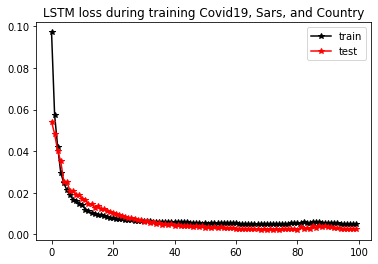

In [39]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("LSTM loss during training Covid19, Sars, and Country")
plt.savefig("LSTMLOSS_Covid19_Sars_country.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.00450330 MSE (0.06710666 RMSE ) , 73.54801613  ACC
Validation Score: 0.00247609 MSE (0.04976031 RMSE ) , 52.77458310  ACC


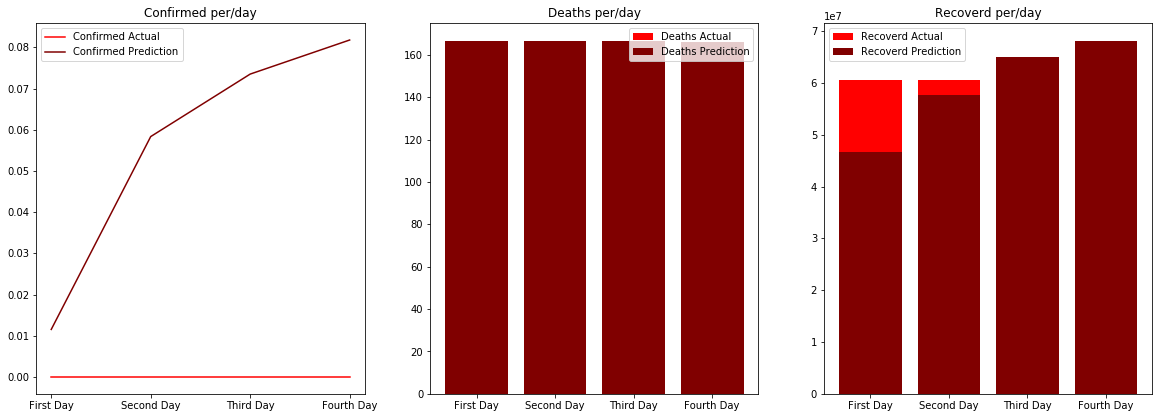

In [92]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,1][0],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,1][0],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,2][0],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,2][0],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()

plt.show()

# Seq2Seq

In [41]:
input_shape = (2, data.shape[1])
model = seq2seq(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc',rmse,mse,r_square])
history = model.fit(x_train, y_train, batch_size=256,epochs=100,shuffle=False ,validation_data=(x_validate, y_validate))

Train on 6956 samples, validate on 1739 samples
Epoch 1/100
6956/6956 [==============================] - 6s 875us/step - loss: 0.0773 - acc: 0.3172 - rmse: 0.2721 - mse: 0.0773 - r_square: 0.1515 - val_loss: 0.0338 - val_acc: 0.7714 - val_rmse: 0.1833 - val_mse: 0.0338 - val_r_square: 0.6847
Epoch 2/100
6956/6956 [==============================] - 1s 160us/step - loss: 0.0408 - acc: 0.3534 - rmse: 0.1976 - mse: 0.0408 - r_square: 0.5637 - val_loss: 0.0339 - val_acc: 0.7736 - val_rmse: 0.1832 - val_mse: 0.0339 - val_r_square: 0.6829
Epoch 3/100
6956/6956 [==============================] - 1s 162us/step - loss: 0.0225 - acc: 0.3662 - rmse: 0.1424 - mse: 0.0225 - r_square: 0.7457 - val_loss: 0.0237 - val_acc: 0.7742 - val_rmse: 0.1510 - val_mse: 0.0237 - val_r_square: 0.7776
Epoch 4/100
6956/6956 [==============================] - 1s 158us/step - loss: 0.0174 - acc: 0.7273 - rmse: 0.1190 - mse: 0.0174 - r_square: 0.7992 - val_loss: 0.0223 - val_acc: 0.8656 - val_rmse: 0.1460 - val_mse: 0.

6956/6956 [==============================] - 1s 145us/step - loss: 0.0051 - acc: 0.6125 - rmse: 0.0478 - mse: 0.0051 - r_square: 0.9421 - val_loss: 0.0023 - val_acc: 0.1482 - val_rmse: 0.0413 - val_mse: 0.0023 - val_r_square: 0.9786
Epoch 68/100
6956/6956 [==============================] - 1s 142us/step - loss: 0.0052 - acc: 0.5271 - rmse: 0.0494 - mse: 0.0052 - r_square: 0.9403 - val_loss: 0.0027 - val_acc: 0.7394 - val_rmse: 0.0452 - val_mse: 0.0027 - val_r_square: 0.9751
Epoch 69/100
6956/6956 [==============================] - 1s 142us/step - loss: 0.0053 - acc: 0.5899 - rmse: 0.0511 - mse: 0.0053 - r_square: 0.9396 - val_loss: 0.0021 - val_acc: 0.1524 - val_rmse: 0.0393 - val_mse: 0.0021 - val_r_square: 0.9801
Epoch 70/100
6956/6956 [==============================] - 1s 143us/step - loss: 0.0050 - acc: 0.5187 - rmse: 0.0478 - mse: 0.0050 - r_square: 0.9424 - val_loss: 0.0020 - val_acc: 0.7294 - val_rmse: 0.0370 - val_mse: 0.0020 - val_r_square: 0.9815
Epoch 71/100
6956/6956 [=====

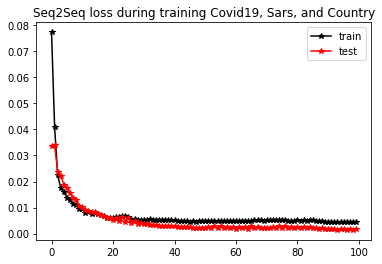

In [42]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("Seq2Seq loss during training Covid19, Sars, and Country")
plt.savefig("Seq2SeqLOSS_Covid19_Sars_country.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.00447450 MSE (0.06689171 RMSE ) , 58.73346755  ACC
Validation Score: 0.00221445 MSE (0.04705799 RMSE ) , 71.24784359  ACC


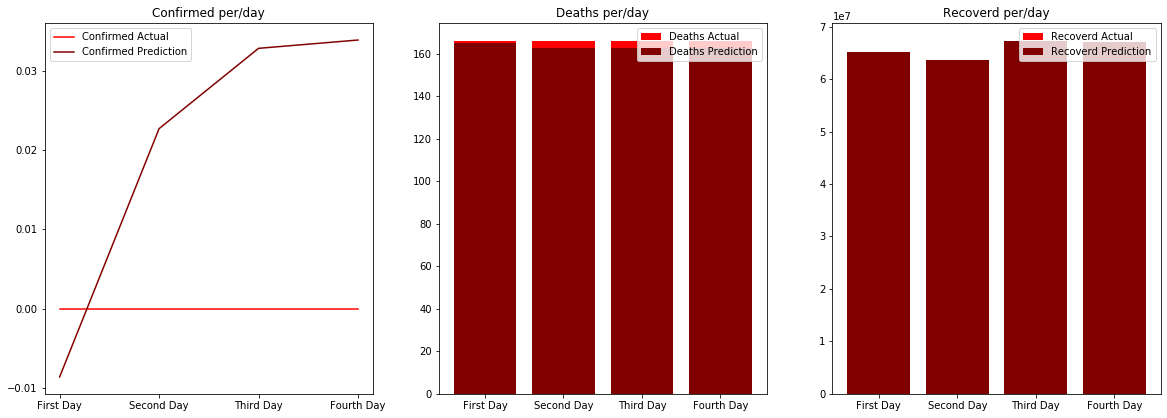

In [103]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,1][0],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,1][0],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,2][0],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,2][0],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()

plt.show()

# GRU

In [44]:
input_shape = (2, data.shape[1])
model = base_model2(data.shape[1], 4, input_shape)
model.compile(loss='mse', optimizer='adam',metrics=['acc',rmse,mse,r_square])
history = model.fit(x_train, y_train, batch_size=256,epochs=200,shuffle=False ,validation_data=(x_validate, y_validate))

Train on 6956 samples, validate on 1739 samples
Epoch 1/200
6956/6956 [==============================] - 5s 650us/step - loss: 0.0791 - acc: 0.1936 - rmse: 0.2764 - mse: 0.0791 - r_square: 0.1273 - val_loss: 0.0484 - val_acc: 0.7714 - val_rmse: 0.2190 - val_mse: 0.0484 - val_r_square: 0.5482
Epoch 2/200
6956/6956 [==============================] - 1s 93us/step - loss: 0.0381 - acc: 0.3521 - rmse: 0.1896 - mse: 0.0381 - r_square: 0.5816 - val_loss: 0.0348 - val_acc: 0.7747 - val_rmse: 0.1838 - val_mse: 0.0348 - val_r_square: 0.6748
Epoch 3/200
6956/6956 [==============================] - 1s 92us/step - loss: 0.0256 - acc: 0.5683 - rmse: 0.1504 - mse: 0.0256 - r_square: 0.7104 - val_loss: 0.0260 - val_acc: 0.7753 - val_rmse: 0.1581 - val_mse: 0.0260 - val_r_square: 0.7568
Epoch 4/200
6956/6956 [==============================] - 1s 92us/step - loss: 0.0196 - acc: 0.4114 - rmse: 0.1278 - mse: 0.0196 - r_square: 0.7770 - val_loss: 0.0207 - val_acc: 0.8181 - val_rmse: 0.1401 - val_mse: 0.020

6956/6956 [==============================] - 1s 83us/step - loss: 0.0050 - acc: 0.6237 - rmse: 0.0475 - mse: 0.0050 - r_square: 0.9426 - val_loss: 0.0015 - val_acc: 0.3643 - val_rmse: 0.0289 - val_mse: 0.0015 - val_r_square: 0.9863
Epoch 68/200
6956/6956 [==============================] - 1s 82us/step - loss: 0.0050 - acc: 0.6182 - rmse: 0.0478 - mse: 0.0050 - r_square: 0.9431 - val_loss: 0.0016 - val_acc: 0.9480 - val_rmse: 0.0314 - val_mse: 0.0016 - val_r_square: 0.9849
Epoch 69/200
6956/6956 [==============================] - 1s 90us/step - loss: 0.0051 - acc: 0.6587 - rmse: 0.0479 - mse: 0.0051 - r_square: 0.9422 - val_loss: 0.0017 - val_acc: 0.4156 - val_rmse: 0.0321 - val_mse: 0.0017 - val_r_square: 0.9846
Epoch 70/200
6956/6956 [==============================] - 1s 83us/step - loss: 0.0050 - acc: 0.6374 - rmse: 0.0476 - mse: 0.0050 - r_square: 0.9432 - val_loss: 0.0015 - val_acc: 0.7270 - val_rmse: 0.0296 - val_mse: 0.0015 - val_r_square: 0.9859
Epoch 71/200
6956/6956 [=========

6956/6956 [==============================] - 1s 84us/step - loss: 0.0048 - acc: 0.5744 - rmse: 0.0451 - mse: 0.0048 - r_square: 0.9456 - val_loss: 0.0017 - val_acc: 0.6653 - val_rmse: 0.0334 - val_mse: 0.0017 - val_r_square: 0.9842
Epoch 134/200
6956/6956 [==============================] - 1s 83us/step - loss: 0.0045 - acc: 0.7502 - rmse: 0.0404 - mse: 0.0045 - r_square: 0.9486 - val_loss: 0.0024 - val_acc: 0.8732 - val_rmse: 0.0417 - val_mse: 0.0024 - val_r_square: 0.9776
Epoch 135/200
6956/6956 [==============================] - 1s 81us/step - loss: 0.0045 - acc: 0.5820 - rmse: 0.0413 - mse: 0.0045 - r_square: 0.9487 - val_loss: 0.0016 - val_acc: 0.8851 - val_rmse: 0.0319 - val_mse: 0.0016 - val_r_square: 0.9849
Epoch 136/200
6956/6956 [==============================] - 1s 82us/step - loss: 0.0046 - acc: 0.6856 - rmse: 0.0427 - mse: 0.0046 - r_square: 0.9472 - val_loss: 0.0024 - val_acc: 0.8880 - val_rmse: 0.0419 - val_mse: 0.0024 - val_r_square: 0.9776
Epoch 137/200
6956/6956 [=====

6956/6956 [==============================] - 1s 85us/step - loss: 0.0042 - acc: 0.6743 - rmse: 0.0365 - mse: 0.0042 - r_square: 0.9518 - val_loss: 0.0014 - val_acc: 0.9380 - val_rmse: 0.0271 - val_mse: 0.0014 - val_r_square: 0.9872
Epoch 200/200
6956/6956 [==============================] - 1s 81us/step - loss: 0.0042 - acc: 0.6759 - rmse: 0.0359 - mse: 0.0042 - r_square: 0.9521 - val_loss: 0.0014 - val_acc: 0.7016 - val_rmse: 0.0275 - val_mse: 0.0014 - val_r_square: 0.9870


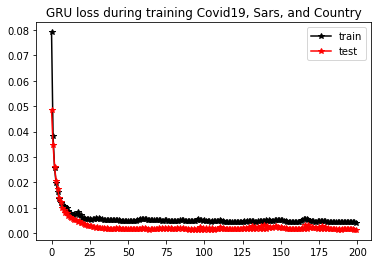

In [45]:
plt.plot(history.history['loss'],'k-*',label='train')
plt.plot(history.history['val_loss'],'r-*', label='test')
plt.legend()
plt.title("GRU loss during training Covid19, Sars, and Country")
plt.savefig("GRULOSS_Covid19_Sars_country.pdf", bbox_inches='tight')
plt.show()

----------------------------------------------------------------------------------------------------
Train Score: 0.00448124 MSE (0.06694208 RMSE ) , 86.97886720  ACC
Validation Score: 0.00166698 MSE (0.04082868 RMSE ) , 93.64577343  ACC


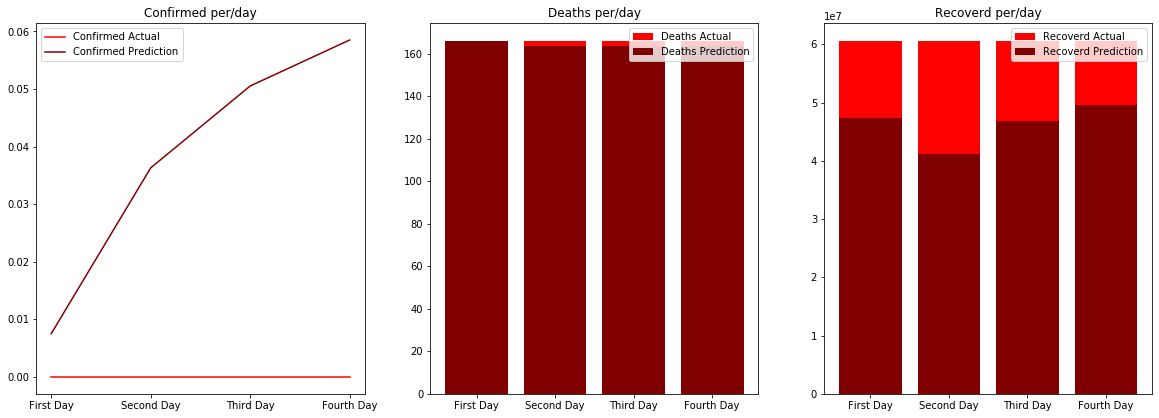

In [108]:
import math 
print('-' * 100)
train_score = model.evaluate(x=x_train, y=y_train, batch_size=3, verbose=0)
print('Train Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (train_score[0], math.sqrt(train_score[0]),train_score[1]*100)  )


validate_score = model.evaluate(x=x_validate, y=y_validate, batch_size=3, verbose=0)
print('Validation Score: %.8f MSE (%.8f RMSE ) , %.8f  ACC' % (validate_score[0], math.sqrt(validate_score[0]),validate_score[1]*100))
train_predict = model.predict(x_train)
validate_predict = model.predict(x_validate)
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data
train_predict = inverse_normalize_data(train_predict, scaler)
y_train = inverse_normalize_data(y_train, scaler)
validate_predict = inverse_normalize_data(validate_predict, scaler)
y_validate = inverse_normalize_data(y_validate, scaler)
#test_predict = inverse_normalize_data(test_predict, scaler)
day = ['First Day','Second Day','Third Day','Fourth Day']
#dfx = pd.DataFrame(data=[y_validate[:], validate_predict])
#dfx = dfx.T
#dfx
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)

ax1.plot(day,y_validate[:,:,0][0],color='red',label='Confirmed Actual')
ax1.plot(day,validate_predict[:,:,0][0],color='maroon',label='Confirmed Prediction')
ax1.title.set_text("Confirmed per/day")
ax1.legend()


ax2.bar(day,y_validate[:,:,1][0],color='red',label='Deaths Actual')
ax2.bar(day,validate_predict[:,:,1][0],color='maroon',label='Deaths Prediction')
ax2.title.set_text("Deaths per/day")
ax2.legend()


ax3.bar(day,y_validate[:,:,2][0],color='red',label='Recoverd Actual')
ax3.bar(day,validate_predict[:,:,2][0],color='maroon',label='Recoverd Prediction')
ax3.title.set_text("Recoverd per/day")
ax3.legend()

plt.show()